In [1]:
# Importing required modules
import pandas as pd
import math
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

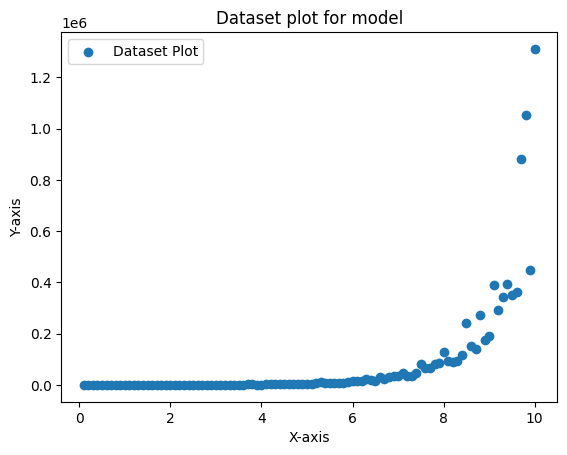

In [2]:
# Reading the dataset.
df = pd.read_csv('Data2.csv')

# Plotting dataset to predict model for the prediction.
plt.scatter(df['x'], df['y'], label='Dataset Plot')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.title('Dataset plot for model')
plt.legend()
plt.show()

In [3]:
# Based on the above plot defining model.
# Defining model if above plot look like exponential.
column_names = [c for c in df.columns if 'sl' not in c.lower()]
output_data = []
for i in range(len(df)):
    # Reducing to straight line by log transformation.
    output_data.append(math.log(df[column_names[-1]][i]))

In [4]:
# Creating matrix A for the calculation.
matrix_A = [[0] * (len(column_names)) for _ in range((len(column_names)))]
y_X_vector = [0] * (len(column_names))
def matrix_and_YX_vector(df, column_names):
    '''Modifies the matrix calculated and yx product.
    df is length of dataset anf column_names is features names list.'''
    # Defining c the value to insert as new dimension in dataset.
    c = 1
    for i in range(len(df)):
        #This handles the creating of d by d matrix as well as summation.
        for j in range(len(column_names)):                
            for k in range(len(column_names)):
                # Thes control statements handles the insertiong of new dimension.
                if j == len(column_names) - 1 and k == len(column_names) - 1:
                    matrix_A[j][k] += c * c
                elif j == len(column_names) - 1 and k != len(column_names) - 1:
                    matrix_A[j][k] += c * df[column_names[k]][i]
                elif  j != len(column_names) - 1 and k == len(column_names) - 1:
                    matrix_A[j][k] += df[column_names[j]][i] *  c
                else:
                    matrix_A[j][k] += df[column_names[j]][i] * df[column_names[k]][i] 

            # This control statements calculate YiXi vector and it's summation over whole datapoints.    
            if j == len(column_names) - 1:
                y_X_vector[j] += output_data[i] * c
            else:
                y_X_vector[j] += output_data[i] * df[column_names[j]][i]
matrix_and_YX_vector(df, column_names)

In [5]:
# taking inverse of the matrix.
def invert_A(m):
    """m is a square matrix."""
    return np.linalg.inv(m)

inverse_A = invert_A(matrix_A)

In [6]:
# Calculating w vector.
w_vector = []
def calc_w_vector(inverse_A):
    '''Calculates w vector. parameter inverse_A is a inverse matrix.'''
    for j in range(len(inverse_A)):
        v = 0
        for k in range(len(y_X_vector)):
            v += inverse_A[j][k] * y_X_vector[k]
        w_vector.append(v)
calc_w_vector(inverse_A)

# Predicting y axis.
x = df['x']
y = df['y']
y_predicted = []
for i in range(len(df)):
    # for exponential model.
    y_predicted.append(math.exp(w_vector[0] * df['x'][i] + w_vector[1]))

In [7]:
# predicting with linear regression from scikit learn.
regr = LinearRegression()

x_array = np.array(df['x']).reshape(-1, 1)
y_array = np.array(output_data).reshape(-1, 1)

regr.fit(x_array,y_array)

y_pred_array = regr.predict(x_array)

# Converting predicted y for straight line to exponential again.
y_pred_list = list(math.exp(y[0]) for y in y_pred_array)

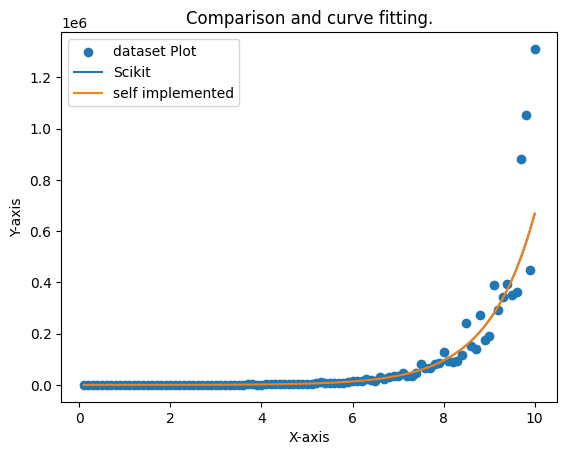

In [8]:
# Fitting both curve scikit and my own to dataset for verification.
plt.scatter(x, y, label='dataset Plot')
plt.plot(x, y_pred_list, label='Scikit')
plt.plot(x, y_predicted, label='self implemented')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.title('Comparison and curve fitting.')
plt.legend()
plt.show()

In [9]:
# Comparing w_vectors.
print("vector from scikit", [regr.coef_, regr.intercept_])
print("vector from own implementation", w_vector)

vector from scikit [array([[0.97299745]]), array([3.68212267])]
vector from own implementation [0.9729974518460578, 3.6821226662931856]


In [10]:
def R_square(y, yp):
    rss = 0
    tss = 0
    m = np.mean(y)
    for i in range(len(y)):
        rss += (y[i] - yp[i]) ** 2
        tss += (y[i] - m) ** 2
    return 1 - (rss/tss)

In [11]:
# Comparing r square with my own and scikit.
print(R_square(y, y_predicted))
print(R_square(y, y_pred_list))
result = R_square(y, y_predicted) - R_square(y, y_pred_list) < 0.1
if result:
    print('Result matched.')
else:
    print("didn't matched.")

0.7882858000815358
0.788285800081534
Result matched.


Finding curve fitting where loss function is minimized by gradient descent.

In [12]:
# w_t+1 = w_t + eta* gradient
df = df.drop(columns='y')
def gradient(w, df):
    result = 0
    s_df = df.sample(frac=1, axis=1, random_state=42) # shuffling the columns of dataframe
    for i in range(len(s_df)):
        r= np.array(s_df.iloc[i][:])
        y_hat = r@w
        result += (math.log(y[i])-y_hat)*s_df.iloc[i][:]
    return (result*(-2)/len(df)).values.reshape((-1,1))

In [40]:
eta = 0.00001
w_o = np.zeros((len(column_names) - 1, 1)) #initialize all w with zero.
epoch = 0
while True:
    w_n = w_o - eta*(gradient(w_o,df))
    up = w_o - w_n
    down = w_n
    epoch += 1
    if np.linalg.norm(up)/np.linalg.norm(down) <= 1e-4:
        break  
    w_o = w_n
w = np.array(w_o)
print("epoch:", epoch)
print(w)

epoch: 3030
[[1.3266423]]


In [41]:
y_predicted_g = []
for i in range(len(df)):
    y_predicted_g.append(math.exp(w[0][0] * x[i]))

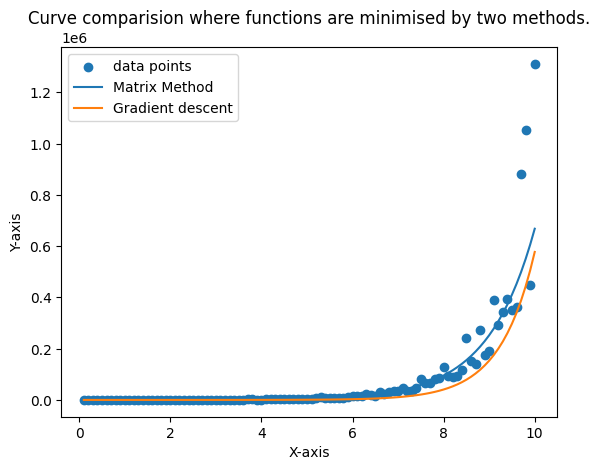

In [42]:
# Plotting curves.
plt.scatter(x, y, label='data points')
plt.plot(x, y_predicted, label='Matrix Method')
plt.plot(x, y_predicted_g, label='Gradient descent')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.title('Curve comparision where functions are minimised by two methods.')
plt.legend()
plt.show()

In [43]:
print("R square obtained:", R_square(y, y_predicted_g))

R square obtained: 0.681116723996152
